In [1]:
#1 Install required packages
!pip install biopython scikit-learn matplotlib seaborn joblib pandas numpy ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.3 MB/s eta 0:00:0000:0100:01


In [5]:
#2 Initialize global variables
global species1, species2, features1, features2, hybrid, crossover_points, hybrid_features, seq_list, dataset, model, viability, success_rate

species1, species2 = "", ""
features1, features2 = {}, {}
hybrid, crossover_points = "", []
hybrid_features = {}
seq_list = []
dataset = None
model = None
viability, success_rate = None, None

print("Global variables initialized. Proceed to next cell.")

Global variables initialized. Proceed to next cell.


In [8]:
import logging
import random
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import ipywidgets as widgets
from IPython.display import display

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)
%matplotlib inline

# File selection widgets
fasta_dir = "/kaggle/input/fasta-dataset-v5"
fasta_files = [f for f in os.listdir(fasta_dir) if f.endswith((".fasta", ".fa", ".fna"))]

# Debug: Print available FASTA files
print("Available FASTA files:", fasta_files)

file_dropdown1 = widgets.Dropdown(
    options=fasta_files,
    description="Species 1:",
    layout=widgets.Layout(width='50%')
)

file_dropdown2 = widgets.Dropdown(
    options=fasta_files,
    description="Species 2:",
    layout=widgets.Layout(width='50%')
)

submit_button = widgets.Button(description="Load Sequences", button_style='success')
output = widgets.Output()

def on_submit_clicked(b):
    global species1, species2
    try:
        with output:
            output.clear_output()
            file1 = os.path.join(fasta_dir, file_dropdown1.value)
            file2 = os.path.join(fasta_dir, file_dropdown2.value)
            
            print(f"Loading file 1: {file1}")
            print(f"Loading file 2: {file2}")
            
            # Use fasta-pearson to handle comments
            seq1 = next(SeqIO.parse(file1, "fasta-pearson"), None)
            seq2 = next(SeqIO.parse(file2, "fasta-pearson"), None)
            
            if seq1 is None or seq2 is None:
                raise ValueError(f"Invalid FASTA file(s). Check if {file1} or {file2} contains valid sequences.")
            
            species1 = str(seq1.seq)
            species2 = str(seq2.seq)
            
            if not species1 or not species2:
                raise ValueError("One or both sequences are empty.")
            
            print(f"✅ Species 1 loaded ({len(species1)} bp)")
            print(f"✅ Species 2 loaded ({len(species2)} bp)")
            
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        species1 = species2 = ""

submit_button.on_click(on_submit_clicked)
display(widgets.VBox([file_dropdown1, file_dropdown2, submit_button, output]))

Available FASTA files: ['Species1_Ecoli_Like.fasta', 'Species2_Salmonella_Like.fasta']


In [9]:
#Cell 4: Sequence Analysis
def analyze_sequence(sequence: str) -> dict:
    """Calculate genomic features of a DNA sequence"""
    if not sequence:
        raise ValueError("Cannot analyze empty sequence")
    
    return {
        'gc_content': gc_fraction(sequence) * 100,
        'length': len(sequence),
        'at_content': (sequence.count('A') + sequence.count('T')) / len(sequence) * 100,
        'dinucleotide_cg': sequence.count('CG') / (len(sequence) - 1) if len(sequence) > 1 else 0
    }

try:
    global features1, features2
    if not species1 or not species2:
        raise ValueError("Load sequences first using the widgets above")
    
    # Analyze parent sequences
    features1 = analyze_sequence(species1)
    features2 = analyze_sequence(species2)
    
    print("\n🔬 Parent Sequence Analysis:")
    print(f"Species 1 - GC: {features1['gc_content']:.2f}% | AT: {features1['at_content']:.2f}% | Length: {features1['length']} bp | CG Dinucleotide: {features1['dinucleotide_cg']:.4f}")
    print(f"Species 2 - GC: {features2['gc_content']:.2f}% | AT: {features2['at_content']:.2f}% | Length: {features2['length']} bp | CG Dinucleotide: {features2['dinucleotide_cg']:.4f}")

except Exception as e:
    logger.error(f"Analysis failed: {e}")
    raise


🔬 Parent Sequence Analysis:
Species 1 - GC: 52.63% | AT: 47.37% | Length: 247 bp | CG Dinucleotide: 0.0325
Species 2 - GC: 52.63% | AT: 47.37% | Length: 247 bp | CG Dinucleotide: 0.0325


In [10]:
#Cell 5: Sequence Fusion
def create_hybrid(seq1: str, seq2: str, window_size: int = 100) -> tuple:
    """Generate hybrid sequence with alternating window segments and random mutations"""
    min_length = min(len(seq1), len(seq2))
    fused = []
    crossovers = []
    
    for i in range(0, min_length, window_size):
        source = seq1 if (i//window_size) % 2 == 0 else seq2
        segment = source[i:i+window_size]
        # Introduce random mutations (1% chance per base)
        segment = ''.join(c if random.random() > 0.01 else random.choice('ACGT') for c in segment)
        fused.append(segment)
        crossovers.append(i)
    
    hybrid_seq = ''.join(fused)
    return hybrid_seq, crossovers

try:
    global hybrid, crossover_points, hybrid_features
    if not species1 or not species2:
        raise ValueError("Load sequences first")
    hybrid, crossover_points = create_hybrid(species1, species2)
    hybrid_features = analyze_sequence(hybrid)
    
    print(f"\n🧬 Hybrid Sequence Created ({len(hybrid)} bp)")
    print(f"Hybrid GC Content: {hybrid_features['gc_content']:.2f}%")
    print(f"Hybrid AT Content: {hybrid_features['at_content']:.2f}%")
    print(f"CG Dinucleotide: {hybrid_features['dinucleotide_cg']:.4f}")
    print(f"First 5 crossover points: {crossover_points[:5]}...")

except Exception as e:
    logger.error(f"Fusion failed: {e}")
    raise


🧬 Hybrid Sequence Created (247 bp)
Hybrid GC Content: 52.63%
Hybrid AT Content: 47.37%
CG Dinucleotide: 0.0325
First 5 crossover points: [0, 100, 200]...


In [11]:
#Cell 6: Simulation and Training
train_input = widgets.Textarea(
    placeholder="Enter FASTA paths (one per line)",
    description="Training Files:",
    layout={'width': '600px', 'height': '150px'}
)
train_button = widgets.Button(description="Generate Training Data")
output = widgets.Output()

def on_train_click(b):
    global dataset
    try:
        with output:
            output.clear_output()
            paths = [os.path.join(fasta_dir, p.strip()) for p in train_input.value.split('\n') if p.strip()]
            sequences = [str(next(SeqIO.parse(p, "fasta")).seq) for p in paths]
            
            # Generate simulated fusions
            data = []
            for _ in range(1000):  # Increased sample size
                s1, s2 = random.sample(sequences, 2)
                window = random.randint(50, 200)
                hybrid, _ = create_hybrid(s1, s2, window)
                features = analyze_sequence(hybrid)
                # Complex viability rule with randomness
                gc = features['gc_content']
                length = features['length']
                cg_freq = features['dinucleotide_cg']
                features['viable'] = 1 if (40 <= gc <= 60 and length > 100 and cg_freq < 0.1 and random.random() > 0.2) else 0
                data.append(features)
            
            dataset = pd.DataFrame(data)
            print(f"\n📊 Training Data Generated ({len(dataset)} samples)")
            print("Viability distribution:")
            print(dataset['viable'].value_counts())
            print("Sample features:")
            print(dataset.head())
            
    except Exception as e:
        print(f"❌ Error: {e}")

train_button.on_click(on_train_click)
display(widgets.VBox([train_input, train_button, output]))

In [12]:
#Cell 7: Model Training
from sklearn.model_selection import cross_val_score

def train_model():
    """Train viability prediction model"""
    if dataset is None or dataset.empty:
        raise ValueError("Dataset not generated. Run Cell 6 first.")
    
    X = dataset[['gc_content', 'length', 'at_content', 'dinucleotide_cg']]
    y = dataset['viable']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    print("\n🎯 Model Performance:")
    print(f"Test Accuracy: {model.score(X_test, y_test):.2%}")
    print(f"Cross-validation Accuracy: {cv_scores.mean():.2%} ± {cv_scores.std():.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, model.predict(X_test)))
    
    return model

try:
    global model
    model = train_model()
    joblib.dump(model, 'viability_model.pkl')
    print("💾 Model saved successfully")
except Exception as e:
    logger.error(f"Training failed: {e}")
    raise


🎯 Model Performance:
Test Accuracy: 79.00%
Cross-validation Accuracy: 80.80% ± 0.51%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        42
           1       0.80      0.97      0.88       158

    accuracy                           0.79       200
   macro avg       0.65      0.53      0.52       200
weighted avg       0.74      0.79      0.73       200

💾 Model saved successfully



📈 Visualization Results:
Predicted probabilities: [0.19539345 0.80460655]


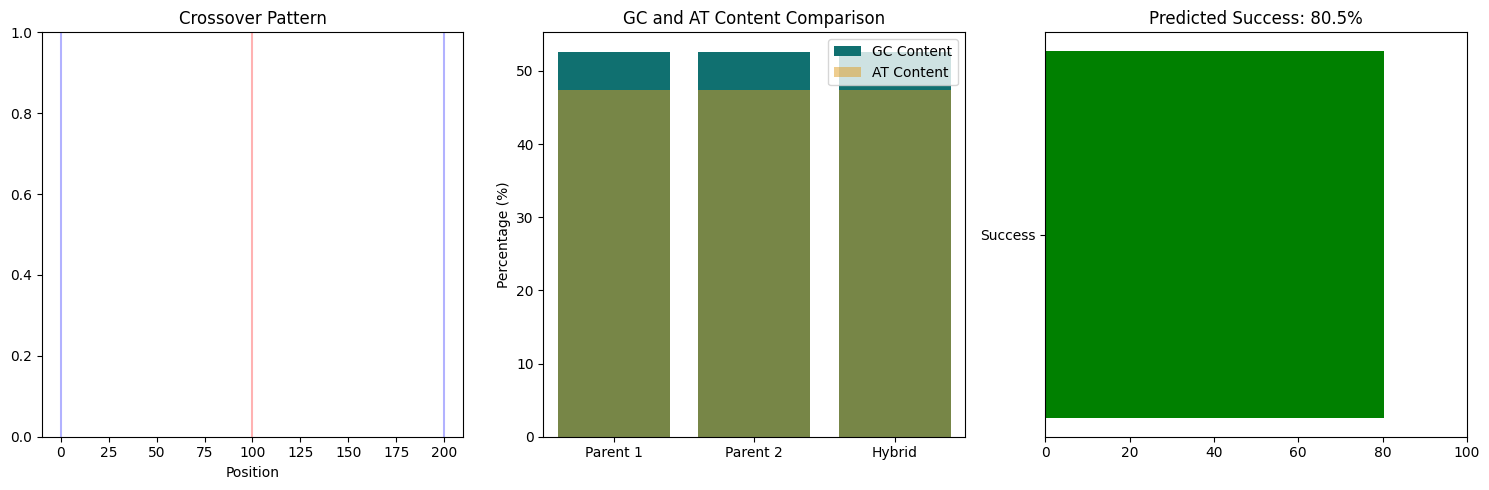

In [13]:
#Cell 8: Visualization
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def visualize_results():
    """Generate comprehensive visualizations"""
    plt.figure(figsize=(15, 5))
    
    # Crossover pattern
    plt.subplot(1, 3, 1)
    for i, point in enumerate(crossover_points):
        plt.axvline(point, color=('blue' if i % 2 == 0 else 'red'), alpha=0.3)
    plt.title("Crossover Pattern")
    plt.xlabel("Position")
    
    # GC and AT comparison
    plt.subplot(1, 3, 2)
    gc_values = [features1['gc_content'], features2['gc_content'], hybrid_features['gc_content']]
    at_values = [features1['at_content'], features2['at_content'], hybrid_features['at_content']]
    x = np.array(['Parent 1', 'Parent 2', 'Hybrid'])
    sns.barplot(x=x, y=gc_values, color='teal', label='GC Content')
    sns.barplot(x=x, y=at_values, color='orange', alpha=0.5, label='AT Content')
    plt.title("GC and AT Content Comparison")
    plt.ylabel("Percentage (%)")
    plt.legend()
    
    # Success prediction
    plt.subplot(1, 3, 3)
    try:
        X_hybrid = pd.DataFrame([hybrid_features])[ ['gc_content', 'length', 'at_content', 'dinucleotide_cg']]
        probs = model.predict_proba(X_hybrid)[0]
        success = 100 * probs[1] if len(probs) > 1 else 0
        plt.barh(['Success'], [success], color=('green' if success > 50 else 'red'))
        plt.xlim(0, 100)
        plt.title(f"Predicted Success: {success:.1f}%")
        # Debug: Print probabilities
        print("Predicted probabilities:", probs)
    except Exception as e:
        plt.text(0.5, 0.5, f"Prediction failed:\n{e}", ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('visualization_results.png')
    plt.show()

try:
    print("\n📈 Visualization Results:")
    visualize_results()
except Exception as e:
    logger.error(f"Visualization failed: {e}")
    raise


📈 Comprehensive Visualization Results:

📈 Enhanced Crossover Pattern:


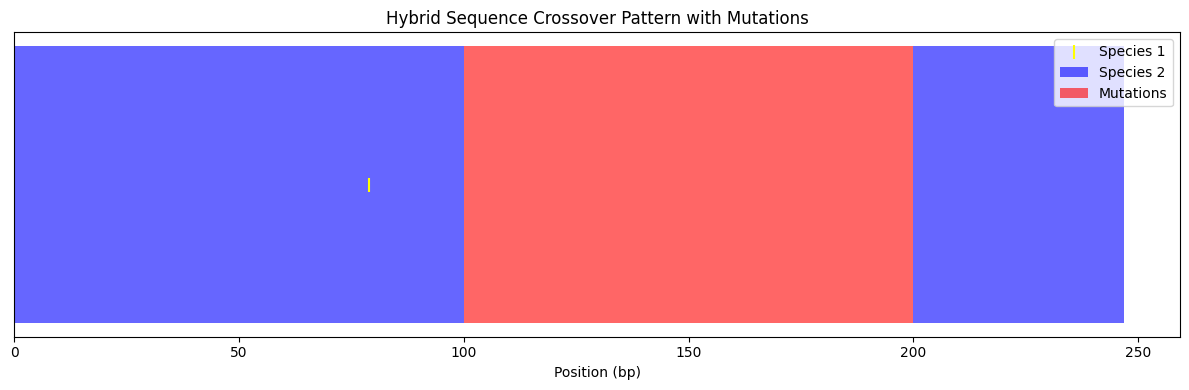


📈 Genomic Feature Distribution:


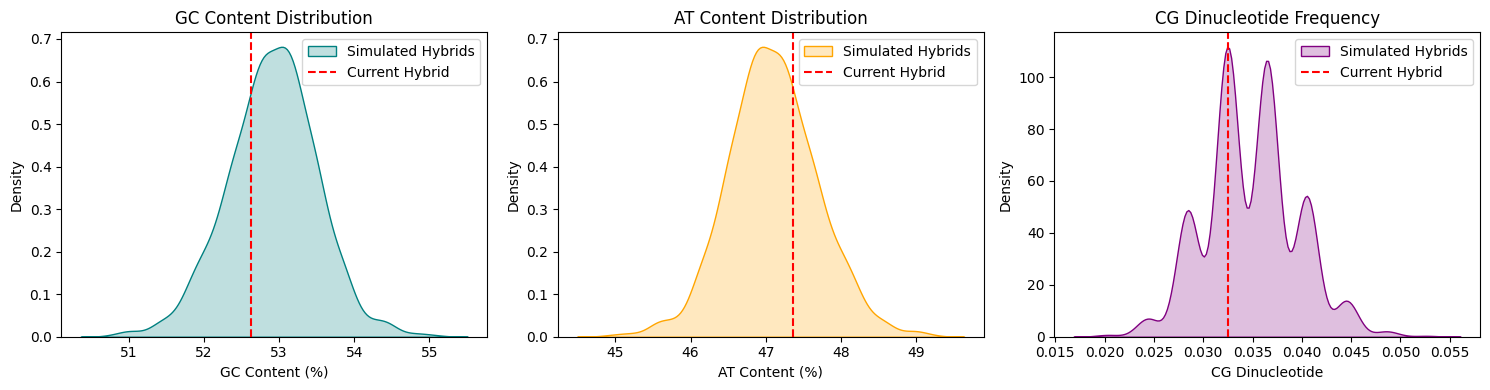


📈 GC and AT Content Comparison:


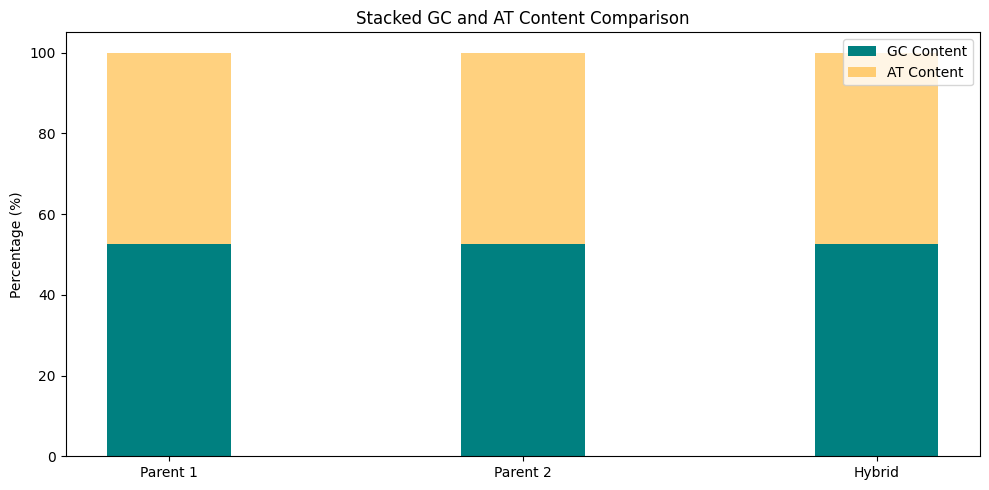


📈 Feature Importance:


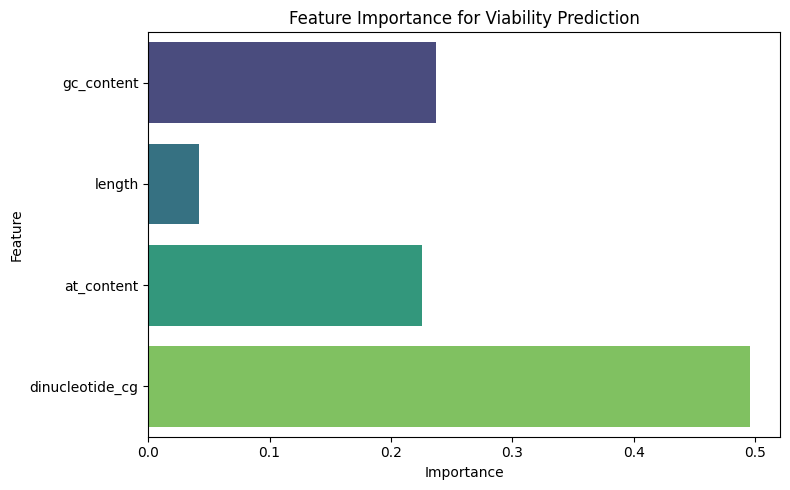


📈 Viability Prediction Confidence:


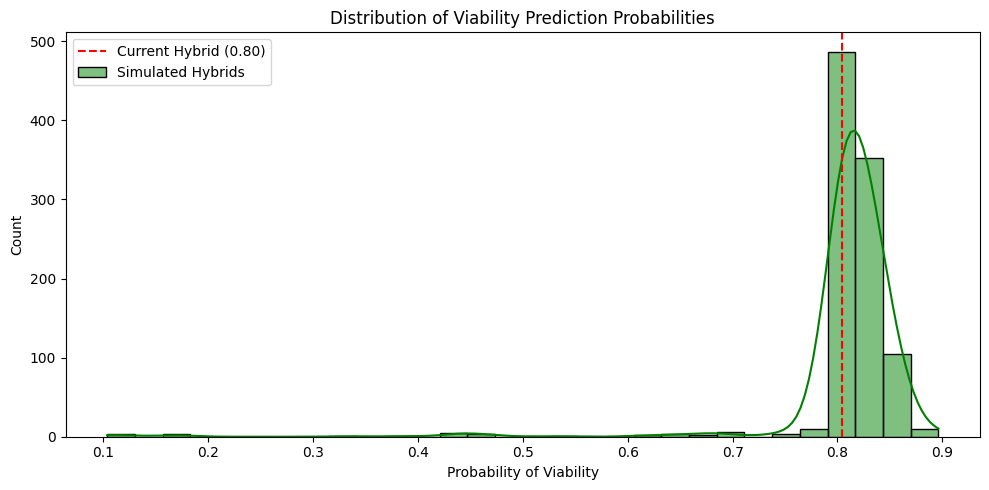


📈 Feature Correlations:


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


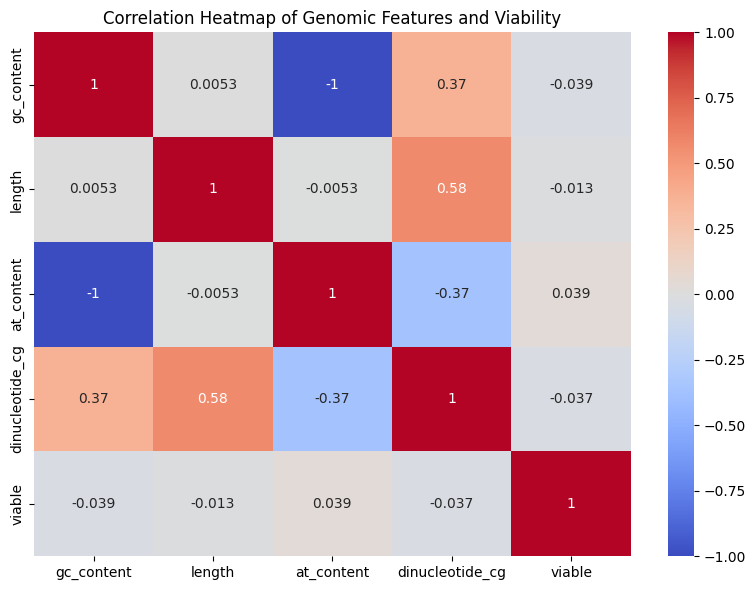

In [23]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

warnings.simplefilter(action='ignore', category=FutureWarning)

# Define new visualization functions
def visualize_crossover_pattern():
    plt.figure(figsize=(12, 4))
    
    # Create arrays for plotting
    segments = []
    colors = []
    mutation_positions = []
    mutation_colors = []
    
    for i, point in enumerate(crossover_points):
        start = point
        end = crossover_points[i + 1] if i + 1 < len(crossover_points) else len(hybrid)
        segments.append((start, end - start))
        colors.append('blue' if i % 2 == 0 else 'red')
        
        # Identify mutations by comparing hybrid to source
        source = species1 if i % 2 == 0 else species2
        segment = hybrid[start:end]
        source_segment = source[start:end]
        for j, (h, s) in enumerate(zip(segment, source_segment)):
            if h != s:
                mutation_positions.append(start + j)
                mutation_colors.append('yellow')
    
    # Plot segments
    for (start, length), color in zip(segments, colors):
        plt.barh(y=0, width=length, left=start, height=0.4, color=color, alpha=0.6)
    
    # Plot mutations
    plt.scatter(mutation_positions, [0] * len(mutation_positions), color='yellow', marker='|', s=100, label='Mutations')
    
    plt.title("Hybrid Sequence Crossover Pattern with Mutations")
    plt.xlabel("Position (bp)")
    plt.yticks([])
    plt.legend(['Species 1', 'Species 2', 'Mutations'], loc='upper right')
    plt.tight_layout()
    plt.savefig('crossover_pattern.png')
    plt.show()

def visualize_feature_distribution():
    if dataset is None or dataset.empty:
        raise ValueError("Training dataset not generated. Run Cell 6 first.")
    
    plt.figure(figsize=(15, 4))
    
    # GC Content
    plt.subplot(1, 3, 1)
    sns.kdeplot(data=dataset, x='gc_content', fill=True, color='teal', label='Simulated Hybrids')
    plt.axvline(hybrid_features['gc_content'], color='red', linestyle='--', label='Current Hybrid')
    plt.title("GC Content Distribution")
    plt.xlabel("GC Content (%)")
    plt.legend()
    
    # AT Content
    plt.subplot(1, 3, 2)
    sns.kdeplot(data=dataset, x='at_content', fill=True, color='orange', label='Simulated Hybrids')
    plt.axvline(hybrid_features['at_content'], color='red', linestyle='--', label='Current Hybrid')
    plt.title("AT Content Distribution")
    plt.xlabel("AT Content (%)")
    plt.legend()
    
    # CG Dinucleotide
    plt.subplot(1, 3, 3)
    sns.kdeplot(data=dataset, x='dinucleotide_cg', fill=True, color='purple', label='Simulated Hybrids')
    plt.axvline(hybrid_features['dinucleotide_cg'], color='red', linestyle='--', label='Current Hybrid')
    plt.title("CG Dinucleotide Frequency")
    plt.xlabel("CG Dinucleotide")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('feature_distribution.png')
    plt.show()

def visualize_feature_importance():
    if model is None:
        raise ValueError("Model not trained. Run Cell 7 first.")
    
    plt.figure(figsize=(8, 5))
    features = ['gc_content', 'length', 'at_content', 'dinucleotide_cg']
    importances = model.feature_importances_
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title("Feature Importance for Viability Prediction")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

def visualize_prediction_confidence():
    if dataset is None or model is None:
        raise ValueError("Dataset or model not generated. Run Cells 6 and 7 first.")
    
    # Predict probabilities for all simulated hybrids
    X = dataset[['gc_content', 'length', 'at_content', 'dinucleotide_cg']]
    probs = model.predict_proba(X)[:, 1]  # Probability of viable class
    
    plt.figure(figsize=(10, 5))
    sns.histplot(probs, bins=30, kde=True, color='green', label='Simulated Hybrids')
    
    # Current hybrid's probability
    X_hybrid = pd.DataFrame([hybrid_features])[['gc_content', 'length', 'at_content', 'dinucleotide_cg']]
    hybrid_prob = model.predict_proba(X_hybrid)[0, 1]
    plt.axvline(hybrid_prob, color='red', linestyle='--', label=f'Current Hybrid ({hybrid_prob:.2f})')
    
    plt.title("Distribution of Viability Prediction Probabilities")
    plt.xlabel("Probability of Viability")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig('prediction_confidence.png')
    plt.show()

def visualize_feature_correlations():
    if dataset is None:
        raise ValueError("Dataset not generated. Run Cell 6 first.")
    
    plt.figure(figsize=(8, 6))
    correlation_matrix = dataset[['gc_content', 'length', 'at_content', 'dinucleotide_cg', 'viable']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title("Correlation Heatmap of Genomic Features and Viability")
    plt.tight_layout()
    plt.savefig('feature_correlations.png')
    plt.show()

def visualize_results():
    """Generate comprehensive visualizations for sequence analysis and model performance"""
    
    # 1. Enhanced Crossover Pattern
    print("\n📈 Enhanced Crossover Pattern:")
    visualize_crossover_pattern()
    
    # 2. Genomic Feature Distribution
    print("\n📈 Genomic Feature Distribution:")
    visualize_feature_distribution()
    
    # 3. Improved GC and AT Comparison
    print("\n📈 GC and AT Content Comparison:")
    plt.figure(figsize=(10, 5))
    gc_values = [features1['gc_content'], features2['gc_content'], hybrid_features['gc_content']]
    at_values = [features1['at_content'], features2['at_content'], hybrid_features['at_content']]
    x = np.array(['Parent 1', 'Parent 2', 'Hybrid'])
    bar_width = 0.35
    plt.bar(x, gc_values, bar_width, color='teal', label='GC Content')
    plt.bar(x, at_values, bar_width, color='orange', alpha=0.5, label='AT Content', bottom=gc_values)
    plt.title("Stacked GC and AT Content Comparison")
    plt.ylabel("Percentage (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig('gc_at_comparison.png')
    plt.show()
    
    # 4. Feature Importance
    print("\n📈 Feature Importance:")
    visualize_feature_importance()
    
    # 5. Viability Prediction Confidence
    print("\n📈 Viability Prediction Confidence:")
    visualize_prediction_confidence()
    
    # 6. Feature Correlations
    print("\n📈 Feature Correlations:")
    visualize_feature_correlations()

try:
    print("\n📈 Comprehensive Visualization Results:")
    visualize_results()
except Exception as e:
    logger.error(f"Visualization failed: {e}")
    raise